In [55]:
import pandas as pd
from datasets import load_dataset
import numpy as np
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
#!pip install seqeval
#!pip install evaluate
import evaluate
import matplotlib.pyplot as plt
import torch
from collections import Counter
from tqdm import tqdm



# Preprocess Data

## Loading in Inspec Dataset with samples

In [3]:
dataset = load_dataset("midas/inspec", "extraction")


print("Samples for Keyphrase Extraction\n")

# sample from the train split
print("Sample from training data split")
train_sample = dataset["train"][0]
print("Fields in the sample: ", [key for key in train_sample.keys()])
print("Tokenized Document: ", train_sample["document"])
print("Document BIO Tags: ", train_sample["doc_bio_tags"])
print("\n-----------\n")

# sample from the validation split
print("Sample from validation data split")
validation_sample = dataset["validation"][0]
print("Fields in the sample: ", [key for key in validation_sample.keys()])
print("Tokenized Document: ", validation_sample["document"])
print("Document BIO Tags: ", validation_sample["doc_bio_tags"])
print("\n-----------\n")

# sample from the test split
print("Sample from test data split")
test_sample = dataset["test"][0]
print("Fields in the sample: ", [key for key in test_sample.keys()])
print("Tokenized Document: ", test_sample["document"])
print("Document BIO Tags: ", test_sample["doc_bio_tags"])
print("\n-----------\n")
print('Type of each dataset:', type(dataset["train"]))

Repo card metadata block was not found. Setting CardData to empty.


Samples for Keyphrase Extraction

Sample from training data split
Fields in the sample:  ['id', 'document', 'doc_bio_tags']
Tokenized Document:  ['A', 'conflict', 'between', 'language', 'and', 'atomistic', 'information', 'Fred', 'Dretske', 'and', 'Jerry', 'Fodor', 'are', 'responsible', 'for', 'popularizing', 'three', 'well-known', 'theses', 'in', 'contemporary', 'philosophy', 'of', 'mind', ':', 'the', 'thesis', 'of', 'Information-Based', 'Semantics', '-LRB-', 'IBS', '-RRB-', ',', 'the', 'thesis', 'of', 'Content', 'Atomism', '-LRB-', 'Atomism', '-RRB-', 'and', 'the', 'thesis', 'of', 'the', 'Language', 'of', 'Thought', '-LRB-', 'LOT', '-RRB-', '.', 'LOT', 'concerns', 'the', 'semantically', 'relevant', 'structure', 'of', 'representations', 'involved', 'in', 'cognitive', 'states', 'such', 'as', 'beliefs', 'and', 'desires', '.', 'It', 'maintains', 'that', 'all', 'such', 'representations', 'must', 'have', 'syntactic', 'structures', 'mirroring', 'the', 'structure', 'of', 'their', 'contents', 

In [4]:
label_list = np.unique(train_sample["doc_bio_tags"])

id2label = {i: label for i, label in enumerate(label_list)}
label2id = {v: k for k, v in id2label.items()}

print('Mapping doc_bio_tag to integer:\n\n',label2id)
print('\nMapping integer to doc_bio_tag:\n\n',id2label)

Mapping doc_bio_tag to integer:

 {'B': 0, 'I': 1, 'O': 2}

Mapping integer to doc_bio_tag:

 {0: 'B', 1: 'I', 2: 'O'}


## Specifying the base model we want

In [5]:
model_checkpoint = "distilroberta-base"

## Getting the same tokenizer that was used in the pre-trained model to preprocess text

General Info: 

A tokenizer breaks unstructured data and natural language text into chunks of information that can be considered as discrete elements.

We use add_prefix_space = True to specify that we want to add a space to the first word if there isn’t already one. This lets us treat 'hello' exactly like 'say hello'.

Although the documents are already tokenized, we want to make sure that the tokenization matches the one that our pre-trained model is expecting.

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
#check to make sure tokenizer has fast version available
tokenizer.is_fast

True

## Convert BIO tags of words to numerical labels (1,2, or 0) corresponding to tokens

Each word in the document gets converted into a token/multiple tokens. After the word is converted into a token we need to assign that token a classification index corresponding to the BIO tag of the word.  This is done with the function below.

see https://huggingface.co/docs/transformers/tasks/token_classification

In [7]:
def tokenize_words_with_corresponding_labels(sample):

    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

    #truncation=True to specify to truncate sequences at the maximum length
    #is_split_into_words = True to specify that our input is already pre-tokenized (e.g., split into words)
    tokenized_inputs = tokenizer(sample["document"], truncation=True, is_split_into_words=True)

    #initialize list to store lists of labels for each sample
    labels = []

    for i, label in enumerate(sample["doc_bio_tags"]):
        
        #map tokens to their respective word
        #word_ids() method gets index of the word that each token comes from
        word_ids = tokenized_inputs.word_ids(batch_index=i)

        #initialize list of labels for each token in a given sample
        label_ids = []

        for word_idx in word_ids:
            
            #set the special tokens, [CLS] and [SEP], to -100.
            # we use -100 because it's an index that is ignored in the loss function we will use (cross entropy).
            if word_idx is None:
                label_ids.append(-100)
            
            #set labels for tokens
            else:
                label_ids.append(label2id[label[word_idx]])
        
        labels.append(label_ids)
   
    tokenized_inputs["labels"] = labels
    
    return tokenized_inputs

In [8]:
tokenized_dataset = dataset.map(tokenize_words_with_corresponding_labels, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

# Finetuning the model with the Trainer API

Token classification with NLP on HuggingFace info 

https://huggingface.co/learn/nlp-course/chapter7/2

## Data collator to pad inputs sequences and labels

In [9]:
#dynamically pad the inputs received, as well as the labels to make them all the same length
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


## Track metrics during training

To have the Trainer compute a metric every epoch, we will need to define a compute_metrics() function that takes the arrays of predictions and labels, and returns a dictionary with the metric names and values.

This compute_metrics() function takes the argmax of the logits to convert them to predictions. Then we have to convert both labels and predictions from integers to strings. We remove all the values where the label is -100, then pass the results to the metric.compute() method.

In [10]:
metric = evaluate.load("seqeval")

In [11]:
def compute_metrics(preds):
    logits, labels = preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return all_metrics

## Defining the model

In [19]:
#hacky way to get around AttributeError: module 'torch.distributed' has no attribute 'is_initialized' error
setattr(torch.distributed, "is_initialized", lambda : False)

In [20]:
torch.manual_seed(0)

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint,
                                                        id2label=id2label,
                                                        label2id=label2id)
#need GPU to train
#_ = model.to('cuda')

#check to make sure we have three labels for outputs
print('Number of labels:', model.config.num_labels)


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of labels: 3


In [21]:
batch_size = 8

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}_finetuned_keyword_extract",
    evaluation_strategy = "epoch",
    logging_strategy = 'epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    lr_scheduler_type='linear',
    weight_decay=0.01,
    seed=0
)

## Define a custom loss using weighted crossentropy

In [49]:
#counting how many beginning keywords, middle keywords, and non-keywords there are
count_0s = 0
count_1s = 0
count_2s = 0

for listt in tokenized_dataset["train"]["labels"]:
    count_dict = Counter(list)
    count_0s += count_dict[0]
    count_1s += count_dict[1]
    count_2s += count_dict[2]

#getting weights for weighted cross_entropy
max_ = max(count_0s,count_1s,count_2s)
weights = [max_/count_0s, max_/count_1s, max_/count_2s]

#defining loss function
def weighted_cross_entropy_loss():
    return torch.nn.CrossEntropyLoss(weight= weights)

## Launch training

In [23]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    compute_loss = weighted_cross_entropy_loss
)
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.316500,0.246156,"{'precision': 0.4042948038176034, 'recall': 0.5368773103326879, 'f1': 0.46124763705103966, 'number': 5681}",0.404295,0.536877,0.461248,0.882515
2,0.216200,0.215921,"{'precision': 0.4719174717537252, 'recall': 0.5073050519274775, 'f1': 0.48897183576518494, 'number': 5681}",0.471917,0.507305,0.488972,0.898571
3,0.195300,0.216909,"{'precision': 0.47417503586800575, 'recall': 0.5817637739834536, 'f1': 0.5224883408426211, 'number': 5681}",0.474175,0.581764,0.522488,0.898383


Trainer is attempting to log a value of "{'precision': 0.4042948038176034, 'recall': 0.5368773103326879, 'f1': 0.46124763705103966, 'number': 5681}" of type <class 'dict'> for key "eval/_" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.4719174717537252, 'recall': 0.5073050519274775, 'f1': 0.48897183576518494, 'number': 5681}" of type <class 'dict'> for key "eval/_" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.47417503586800575, 'recall': 0.5817637739834536, 'f1': 0.5224883408426211, 'number': 5681}" of type <class 'dict'> for key "eval/_" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=375, training_loss=0.24266029357910157, metrics={'train_runtime': 3340.6936, 'train_samples_per_second': 0.898, 'train_steps_per_second': 0.112, 'total_flos': 233540514565200.0, 'train_loss': 0.24266029357910157, 'epoch': 3.0})

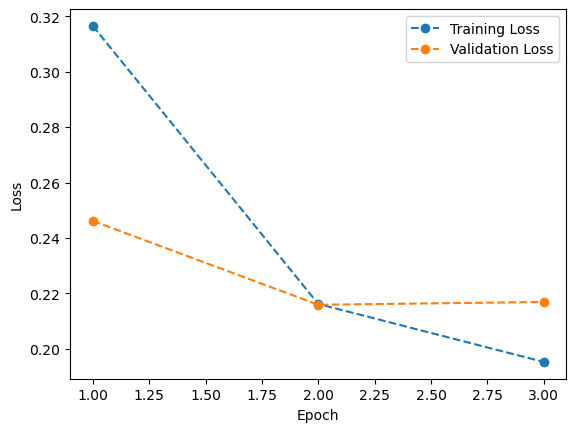

In [31]:
epochs = [1,2,3]
loss = []
val_loss = []
for d in trainer.state.log_history:
    if "loss" in d:
        loss.append(d["loss"])
    if "eval_loss" in d:
        val_loss.append(d["eval_loss"])

plt.plot(epochs, loss, 'o--')
plt.plot(epochs, val_loss, 'o--')
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

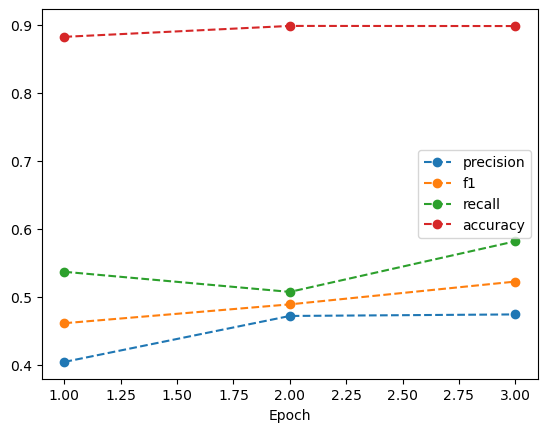

In [32]:
eval_overall_precision = []
eval_overall_f1 = []
eval_overall_recall = []
eval_overall_accuracy = []


for d in trainer.state.log_history:
    if "eval_overall_precision" in d:
        eval_overall_precision.append(d["eval_overall_precision"])
        eval_overall_f1.append(d["eval_overall_f1"])        
        eval_overall_recall.append(d["eval_overall_recall"])
        eval_overall_accuracy.append(d["eval_overall_accuracy"])
        
plt.plot(epochs, eval_overall_precision,'o--', label = 'precision')
plt.plot(epochs, eval_overall_f1, 'o--',label = 'f1')
plt.plot(epochs, eval_overall_recall, 'o--',label = 'recall')
plt.plot(epochs, eval_overall_accuracy, 'o--',label = 'accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [52]:
test_output = trainer.evaluate(tokenized_dataset["test"])
test_output

{'eval_loss': 0.2090981900691986,
 'eval__': {'precision': 0.4913162705667276,
  'recall': 0.5634171907756813,
  'f1': 0.52490234375,
  'number': 5724},
 'eval_overall_precision': 0.4913162705667276,
 'eval_overall_recall': 0.5634171907756813,
 'eval_overall_f1': 0.52490234375,
 'eval_overall_accuracy': 0.9024873128250109,
 'eval_runtime': 91.4641,
 'eval_samples_per_second': 5.467,
 'eval_steps_per_second': 0.689,
 'epoch': 3.0}

In [155]:
def extract_keyphrases(text, model, tokenizer, text_in_list = False):
    
    if text_in_list:
        text = ' '.join(word for word in text)

    inputs = tokenizer(text,return_tensors="pt")["input_ids"]
    with torch.no_grad():
        logits = model(inputs).logits

    predictions = torch.argmax(logits, dim=2)
    predicted_token_class = [model.config.id2label[t.item()] for t in predictions[0]]

    keyphrases = []
    keyphrase = []
    for label, token in zip(predicted_token_class, inputs[0]):
        if label == 'B':
            keyphrase = []
            keyphrase.append(tokenizer.decode(token))
        elif label == 'I' and len(keyphrase) > 0:
            keyphrase.append(tokenizer.decode(token))
        
        elif label == 'O' and len(keyphrase) > 0:
            keyphrases.append(keyphrase)
            keyphrase = []
        
    return keyphrases

In [157]:
extract_keyphrases(dataset["test"][0]["document"], model, tokenizer, True)

[[' graphical', ' user', ' interface'],
 [' computation', ' ph', 'ant', 'oms'],
 ['NP', ' calculations'],
 [' vivo', ' measurement', ' systems'],
 [' computational', ' ph', 'ant', 'oms'],
 [' Carlo', ' calculations'],
 [' data', ' analysis'],
 [' in'],
 ['ion'],
 ['NP'],
 [' computed', ' tom', 'ography'],
 [' magnetic', ' resonance', ' imaging'],
 [' memory', ' demand'],
 [' computed', ' tom'],
 [' magnetic', ' resonance', ' imaging']]

## NEED TO CLEAN UP, PACKAGE INTO SCRIPTS, AND CREATE CONTAINERS FOR PREPROCESS TRAINING